<a href="https://colab.research.google.com/github/KennethV322/unsupervised-predict-streamlit-template/blob/master/Movie_rec_finalv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EA Movie Recommendation Predict 2023-2024**

# **Description**
**Challenge Description**
In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

...ever wondered how Netflix, Amazon Prime, Showmax, Disney and the likes somehow know what to recommend to you?



...it's not just a guess drawn out of the hat. There is an algorithm behind it.

With this context, EA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

**What value is achieved through building a functional recommender system?**
Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

Recommender systems

**Evaluation**
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the formula is given by:
RMSE=1|R^|∑r^ui∈R^(rui−r^ui)2−−−−−−−−−−−−−−−−⎷
Where R^
 is the total number of recommendations generated for users and movies, with rui
 and r^ui
 being the true and predicted ratings for user u
 watching movie i
 respectively.

**Submission Format**
For every author in the dataset, submission files should contain two columns: Id and rating. Id is a concatenation of the userID and movieID given in the test file (using an _ character). rating is the predicted rating for a given user-movie pair

The file should contain a header and have the following format:

Id,rating
1_2011,1.0

# **Table Of Contents:**



1. Importing Packages
2. Loading Data
3. Exploratary Data Analysis
4. Feature Engineering
5. Modelling
6. Model Performance
7. Model Explanations



# **1. Importing Packages**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import re
import string
import nltk
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
import matplotlib.pyplot as plt
import seaborn as sns
# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install scikit-surprise

# **2. Loading Data**

In [31]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_imdb_data = pd.read_csv('imdb_data.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

# **3. Exploratary Data Analysis**

In [32]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669.0,4.0,1.518350e+09
1,106343,5.0,4.5,1.206239e+09
2,146790,5459.0,5.0,1.076216e+09
3,106362,32296.0,2.0,1.423043e+09
4,9041,366.0,3.0,8.333758e+08


In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3531224 entries, 0 to 3531223
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    float64
 2   rating     float64
 3   timestamp  float64
dtypes: float64(3), int64(1)
memory usage: 107.8 MB


In [ ]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [ ]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [ ]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1.439472e+09
1,3,260,sci-fi,1.439472e+09
2,4,1732,dark comedy,1.573944e+09
3,4,1732,great dialogue,1.573944e+09
4,4,7569,so bad it's good,1.573943e+09


In [ ]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035792 entries, 0 to 1035791
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1035792 non-null  int64  
 1   movieId    1035792 non-null  int64  
 2   tag        1035775 non-null  object 
 3   timestamp  1035791 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.6+ MB


In [ ]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851547 entries, 0 to 3851546
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  float64
dtypes: float64(1), int64(1)
memory usage: 58.8 MB


In [ ]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1.0,0.02875
1,1,2.0,0.02375
2,1,3.0,0.06250
3,1,4.0,0.07575
4,1,5.0,0.14075


In [ ]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [ ]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1.439472e+09
1,3,260,sci-fi,1.439472e+09
2,4,1732,dark comedy,1.573944e+09
3,4,1732,great dialogue,1.573944e+09
4,4,7569,so bad it's good,1.573943e+09


In [ ]:
print (f'Number of ratings in dataset: {df_train.shape[0]}')

Number of ratings in dataset: 401318


In [ ]:
print (f'Number of users in dataset: {df_test.shape[0]}')

Number of users in dataset: 978757


Average rating in dataset: 3.5333951730983424


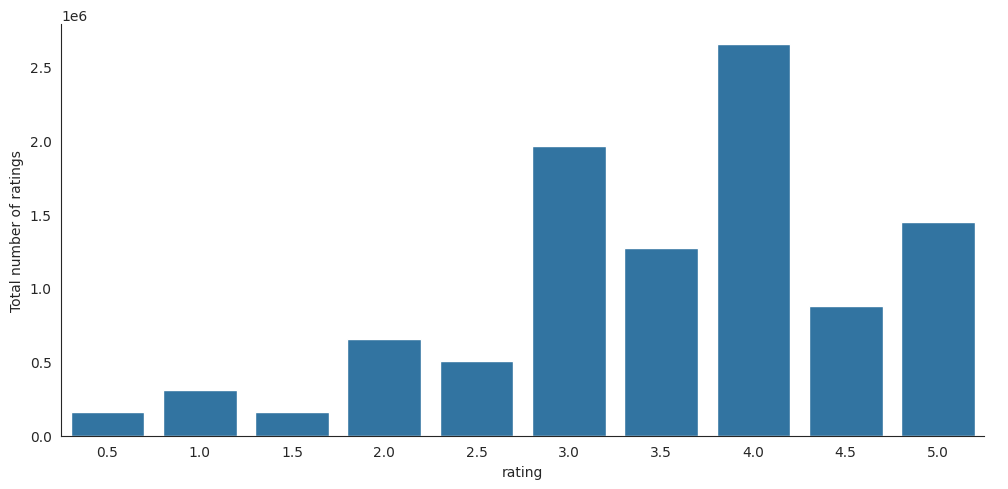

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot(data=df_train, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(df_train["rating"])}')

# **4. Feature Engineering**

In [34]:
users = df_train['userId'].unique()

# Get a random sample of users
sample_users = np.random.choice(users, size=int(0.5 * len(users)), replace=False)

# Get the rows corresponding to the sampled users
df_sample = df_train[df_train['userId'].isin(sample_users)]

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1773641 entries, 0 to 3531222
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    float64
 2   rating     float64
 3   timestamp  float64
dtypes: float64(3), int64(1)
memory usage: 67.7 MB


Average rating in dataset: 3.525871639187412


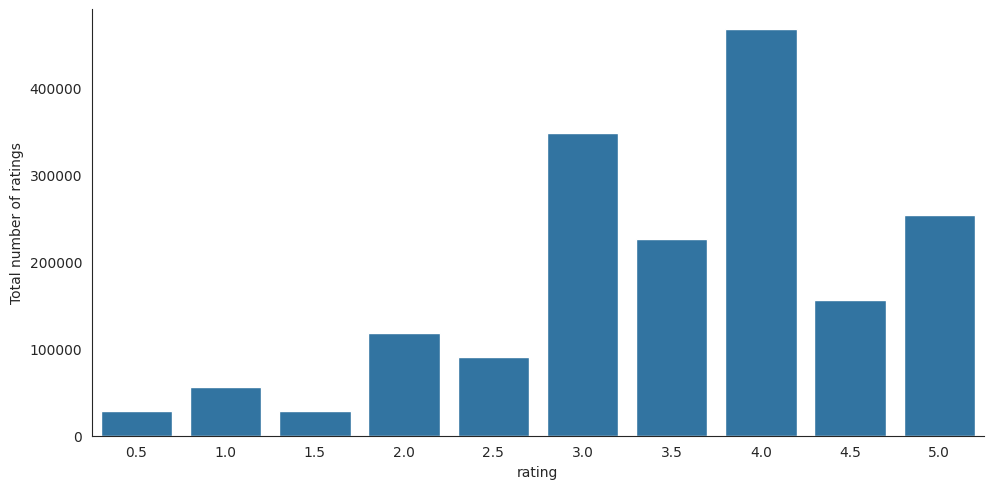

In [35]:
with sns.axes_style('white'):
    g = sns.catplot(data=df_sample, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(df_sample["rating"])}')

In [36]:
df_trainv1 = pd.merge(df_sample, df_movies, on='movieId')

df_trainv2 = df_trainv1[['userId', 'movieId',	'title','rating',	'timestamp']]

df_trainv2.head()

,userId,movieId,title,rating,timestamp
0,5163,57669.0,In Bruges (2008),4.0,1.518350e+09
1,137050,57669.0,In Bruges (2008),4.0,1.425632e+09
2,120490,57669.0,In Bruges (2008),4.5,1.408229e+09
3,50616,57669.0,In Bruges (2008),4.5,1.446942e+09
4,99887,57669.0,In Bruges (2008),0.5,1.448839e+09


In [37]:
df_trainv2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1773641 entries, 0 to 1773640
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    float64
 2   title      object 
 3   rating     float64
 4   timestamp  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 81.2+ MB


In [38]:
merged_df = pd.merge(df_movies, df_imdb_data, on='movieId')

final_df = merged_df[['movieId', 'title', 'title_cast', 'genres', 'director', 'runtime', 'budget',	'plot_keywords']]

final_df.head()

,movieId,title,title_cast,genres,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Adventure|Children|Fantasy,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Comedy|Romance,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Whitney Houston|Angela Bassett|Loretta Devine|...,Comedy|Drama|Romance,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...,Comedy,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [39]:
final_df['director_titlecast'] = (pd.Series(final_df[['director', 'title_cast']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

titles = final_df['title']
indices = pd.Series(final_df.index, index=final_df['title'])

In [40]:
indices.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

In [41]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns
tf_movietags_matrix = tf.fit_transform(final_df['director_titlecast'])

In [42]:
cosine_sim_movietags = cosine_similarity(tf_movietags_matrix,
                                        tf_movietags_matrix)
print (cosine_sim_movietags.shape)

(24866, 24866)


In [ ]:
cosine_sim_movietags[:5]

array([[1.        , 0.        , 0.00481673, ..., 0.00606498, 0.00317293,
        0.01385015],
       [0.        , 1.        , 0.00251314, ..., 0.        , 0.        ,
        0.        ],
       [0.00481673, 0.00251314, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01596706, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00451436, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# **5. Modelling**

In [43]:
def content_generate_top_N_recommendations(movie_title, N=10):
    # Convert the string book title to a numeric index for our
    # similarity matrix
    b_idx = indices[movie_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_movietags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles
    return titles.iloc[book_indices]

In [ ]:
content_generate_top_N_recommendations("Toy Story (1995)", N=10)

3020                                    Toy Story 2 (1999)
14758                                   Toy Story 3 (2010)
23079              Toy Story Toons: Partysaurus Rex (2012)
22140                    Toy Story Toons: Small Fry (2011)
22139            Toy Story Toons: Hawaiian Vacation (2011)
20294                           Toy Story of Terror (2013)
23081                    Toy Story That Time Forgot (2014)
10314    After School Special (a.k.a. Barely Legal) (2003)
20452                                 Tim's Vermeer (2013)
Name: title, dtype: object

In [ ]:
content_generate_top_N_recommendations("Jumanji (1995)", N=10)

23134    Robin Williams: Weapons of Self Destruction (2...
3413                                   Return to Me (2000)
4680                                Little Man Tate (1991)
19327                             Unspeakable Acts (1990) 
2016     Halloween H20: 20 Years Later (Halloween 7: Th...
4062                                     15 Minutes (2001)
4969                   Adventures of Huck Finn, The (1993)
1575                                 Ice Storm, The (1997)
630                                      Diabolique (1996)
Name: title, dtype: object

In [ ]:
content_generate_top_N_recommendations("Father of the Bride Part II (1995)", N=10)

6818            Father of the Bride (1991)
19824                  Scenic Route (2013)
1493               War at Home, The (1996)
5857                        My Girl (1991)
9889     Jiminy Glick in La La Wood (2004)
6099        Bringing Down the House (2003)
1699                   Mass Transit (1998)
11244               We Are Marshall (2006)
10647             Failure to Launch (2006)
Name: title, dtype: object

In [44]:
def content_generate_rating_estimate(movie_title, user, rating_data, k=20, threshold=0.0):
    # Convert the book title to a numeric index for our
    # similarity matrix
    b_idx = indices[movie_title]
    neighbors = [] # <-- Stores our collection of similarity values

    # Gather the similarity ratings between each book the user has rated
    # and the reference book
    for index, row in rating_data[rating_data['userId']==user].iterrows():
        sim = cosine_sim_movietags[b_idx-1, indices[row['title']]-1]
        neighbors.append((sim, row['rating']))
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and
    # user item ratings.
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user.
        # We use the average rating for the reference item as a proxy in this case
        predictedRating = np.mean(rating_data[rating_data['title']==movie_title]['rating'])
    return predictedRating

In [45]:
df_trainv2[df_trainv2['userId'] == 5163][3:10]

,userId,movieId,title,rating,timestamp
588179,5163,2671.0,Notting Hill (1999),1.0,1.545512e+09
776892,5163,1394.0,Raising Arizona (1987),4.0,1.545511e+09
982167,5163,68157.0,Inglourious Basterds (2009),5.0,1.434310e+09
1265660,5163,441.0,Dazed and Confused (1993),4.0,1.518293e+09


In [46]:
title = "In Bruges (2008)"
actual_rating = df_trainv2[(df_trainv2['userId'] == 5163) & (df_trainv2['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=5163, rating_data=df_trainv2)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - In Bruges (2008)
---
Actual rating: 		 4.0
Predicted rating: 	 4.0


In [ ]:
title = "True Lies (1994)"
actual_rating = df_trainv2[(df_trainv2['userId'] == 5163) & (df_trainv2['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=5163, rating_data=df_trainv2)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - True Lies (1994)
---
Actual rating: 		 4.0
Predicted rating: 	 4.0216635715195945


# **Model Performance:**

**SVD Model:**

In [47]:
from surprise import Dataset, Reader

from surprise.model_selection import train_test_split

from surprise import SVD

from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_trainv2[['userId', 'movieId', 'rating']], reader)

trainsnet, testset = train_test_split(data, test_size=0.2)

model = SVD()

model.fit(trainsnet)

predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8972


0.8972361448154189

**SVDpp Model:**

In [49]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVDpp  # Import SVDpp instead of SVD
from surprise import accuracy

reader = Reader(rating_scale=(3, 5))
data = Dataset.load_from_df(df_trainv2[['userId', 'movieId', 'rating']], reader)

# Split the data into 80% trainset and 20% testset
trainset, testset = train_test_split(data, test_size=0.2)

model = SVDpp()  # Use SVDpp instead of SVD

model.fit(trainset)

predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9119


0.911872648650468

**KNN Basic Model:**

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic  # Import KNNBasic instead of SVD
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_trainv2[['userId', 'movieId', 'rating']], reader)

# Split the data into 80% trainset and 20% testset
trainset, testset = train_test_split(data, test_size=0.2)

model = KNNBasic()  # Use KNNBasic instead of SVD

model.fit(trainset)

predictions = model.test(testset)
accuracy.rmse(predictions)

In [ ]:
pip install tensorflow-recommenders
pip install tensorflow-datasets

In [48]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

# Load data on movie ratings.
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Build flexible representation models.
user_model = tf.keras.Sequential([...])
movie_model = tf.keras.Sequential([...])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(movies.batch(128).map(movie_model)))

# Create a retrieval model.
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train.
model.fit(ratings.batch(4096), epochs=3)

# Set up retrieval using trained representations.
index = tfrs.layers.ann.BruteForce(model.user_model)
index.index_from_dataset(movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get recommendations.
_, titles = index(np.array(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

ModuleNotFoundError: No module named 'pymc3'

In [ ]:
# Assuming 'df_test' is your DataFrame with columns 'userId', 'movieId'
reader = Reader(rating_scale=(1, 5))  # rating_scale can be any range, it's not used here

# As df_test doesn't have a 'rating' column, we can create a dummy one
df_test['rating'] = np.zeros(len(df_test))  # create a column of zeros

data_test = Dataset.load_from_df(df_test[['userId', 'movieId', 'rating']], reader)

# Build the testset from the entire data_test Dataset
testset_df_test = data_test.build_full_trainset().build_testset()

# Use the trained model to make predictions on df_test
predictions_df_test = model.test(testset_df_test)

new_data = []
for pred in predictions_df_test:
    id = str(pred.uid) + '_' + str(pred.iid)
    new_data.append([id, pred.est])

df_predictions_df_test = pd.DataFrame(new_data, columns=['Id', 'rating'])

print(df_predictions_df_test)

                  Id    rating
0             1_2011  3.332211
1             1_4144  4.061879
2             1_5767  3.405811
3             1_6711  3.701702
4             1_7318  3.019453
...              ...       ...
5000014  162541_4079  3.536775
5000015  162541_4467  3.764627
5000016  162541_4980  3.187451
5000017  162541_5689  3.247101
5000018  162541_7153  4.043714

[5000019 rows x 2 columns]


In [ ]:
df_predictions_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   rating  float64
dtypes: float64(1), object(1)
memory usage: 76.3+ MB


In [ ]:
df_predictions_df_test.to_csv('pred.csv', index=False)